In [35]:
from model import UNetSegmenter

model = UNetSegmenter.load_from_checkpoint("checkpoints/best-checkpoint-7xsdeoql.ckpt", map_location="cpu").eval()

In [36]:
from data import CloudDataset

test_image_file = "../../../data/image_data/image3.txt"

test_dataset = CloudDataset([test_image_file], train=False)

In [37]:
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import torch

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

trainer = Trainer()
with torch.no_grad():
    predictions = trainer.predict(model, test_loader)[0][0][0]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bogdan/miniconda3/envs/215a/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [38]:
import numpy as np
import pandas as pd

test_image = np.loadtxt(test_image_file)
test_image_df = pd.DataFrame(test_image)
test_image_df = test_image_df.iloc[:, :3]
test_image_df.columns = ["y", "x", "label"]

In [39]:
def attach_predictions(df, predictions):
    df_y_max = df["y"].max()
    df_x_max = df["x"].max()
    
    moved_y = df["y"] - df_y_max
    moved_x = df["x"] - df_x_max
    
    df["prediction"] = predictions[moved_y, moved_x]
    

attach_predictions(test_image_df, predictions)
test_image_df = test_image_df[test_image_df["label"] != 0]

In [40]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_image_df["label"], test_image_df["prediction"])
roc_auc = auc(fpr, tpr)

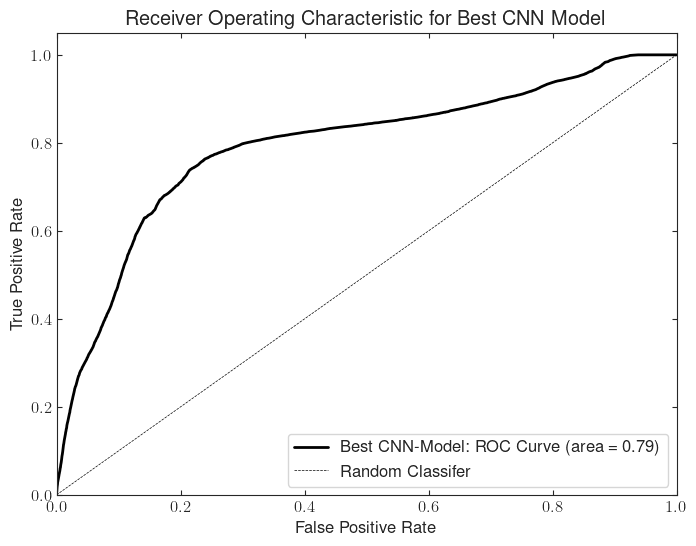

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] =  "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.right"] = True 
plt.rcParams["ytick.left"] = True

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'Best CNN-Model: ROC Curve (area = {roc_auc:.2f})', lw=2, color="black", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=0.5, linestyle='--', errorbar=None, label="Random Classifer")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best CNN Model')
plt.legend(loc="lower right")
plt.savefig("../../../figs/roc_cnn.pdf")
plt.show()

In [45]:
# Save tpr and fpr to compare with other models
roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})
roc_df.to_csv("../../../data/roc_data/roc_cnn.csv", index=False)